<a href="https://colab.research.google.com/github/jglaser/gigadocking_notebooks/blob/main/Gigadocking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Provide your credentials to the runtime

In [2]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


### Declare the Cloud project ID which will be used throughout this notebook

Initially, you'll have to have BigQuery privileges for this project until the datasets are made public.

In [3]:
project_id = 'cmb-covid19-discovery-collab'

## Optional: Enable data table display

Colab includes the ``google.colab.data_table`` package that can be used to display large pandas dataframes as an interactive data table.
It can be enabled with:

In [4]:
%load_ext google.colab.data_table

If you would prefer to return to the classic Pandas dataframe display, you can disable this by running:
```python
%unload_ext google.colab.data_table
```

# Overview of the docking data sets

First we'll gather some metadata on the available datasets and their sizes

In [ ]:
from google.cloud import bigquery
import pandas as pd
import humanize

# Construct a BigQuery client object.
client = bigquery.Client(project=project_id)

datasets = []
tables = []
sizes = []
all_datasets = list(client.list_datasets()) 
for dataset in all_datasets:
    size_bytes = client.query('SELECT size_bytes FROM {}.__TABLES__'.format(dataset.dataset_id)).to_dataframe().values.reshape(-1)
    cur_tables = list(client.list_tables(dataset.dataset_id))
    tables += [t.table_id for t in cur_tables]
    datasets += [dataset.dataset_id for t in cur_tables]
    sizes += size_bytes.tolist()
df = pd.DataFrame({'Dataset': datasets, 'Table': tables, 'Size': sizes})
print('Total size of datasets {}'.format(humanize.naturalsize(df['Size'].sum(),binary=True)))

Total size of datasets 424.2 TiB


In [ ]:
import numpy as np
from google.colab import data_table
from tabulate import tabulate

all_datasets = list(client.list_datasets()) 
df.groupby(['Dataset']).agg({'Size': lambda x: humanize.naturalsize(np.sum(x),binary=True)}).reset_index()

,Dataset,Size
0,enamine_2020q1,246.4 GiB
1,moonshot,326.8 KiB
2,mpro_5r84,110.0 TiB
3,mpro_6wqf,106.0 TiB
4,mpro_ncats,4.2 MiB
5,nsp15_6wlc,85.9 TiB
6,plpro_7jir,11.6 TiB
7,rdrp,7.1 TiB
8,spike_6m0j,85.7 TiB
9,spike_ncats,1.5 MiB


Dig deeper into a single dataset to see the tables it contains

In [ ]:
df[df['Dataset']=='plpro_7jir'][['Table']]

,Table
19,confs_all
20,scores


Expore the table schemas

In [ ]:
!bq show --project_id $project_id plpro_7jir.scores


Welcome to BigQuery! This script will walk you through the 
process of initializing your .bigqueryrc configuration file.

First, we need to set up your credentials if they do not 
already exist.

Credential creation complete. Now we will select a default project.

List of projects:
  #            projectId                     friendlyName          
 --- ------------------------------ ------------------------------ 
  1   cmb-covid19-discovery-collab   cmb-covid19-discovery-collab  
Found only one project, setting cmb-covid19-discovery-collab as the default.

BigQuery configuration complete! Type "bq" to get started.

Table cmb-covid19-discovery-collab:plpro_7jir.scores

   Last modified               Schema               Total Rows   Total Bytes    Expiration   Time Partitioning   Clustered Fields   Labels  
 ----------------- ------------------------------- ------------ -------------- ------------ ------------------- ------------------ -------- 
  11 Feb 03:39:52   |- name: string   

# Query a dataset to return top scores

We'll issue our SQL queries through iPython magics, which runs a query and either displays the result or saves it to a variable as a `DataFrame`.

In [ ]:
# Display query output immediately

%%bigquery --project $project_id
SELECT * FROM mpro_5r84.scores
ORDER BY rf2 DESC LIMIT 200

,name,rank,score,rf2,vs_dude_v2,dcoid
0,Z1785895966_1_T1,5,-6.37,8.527695,6.240727,0.516
1,PV-001938484367_1_T1,8,-6.00,8.437683,6.182937,0.488
2,PV-001915805464_1_T1,19,-5.07,8.403433,6.200973,0.542
3,PV-001842084659_1_T1,3,-7.97,8.359284,6.126051,0.500
4,Z1744525712_2_T1,15,-7.12,8.332914,6.172450,0.476
...,...,...,...,...,...,...
195,PV-001915403326_1_T1,0,-5.99,8.139894,6.157118,0.518
196,PV-001915941453_1_T1,0,-9.76,8.139838,6.031066,0.406
197,PV-002017760997_1_T1,1,-7.77,8.139808,6.083212,0.580
198,Z1151180463_2_T1,1,-9.86,8.139525,6.151793,0.382


In [ ]:
# Save output in a variable `df`

%%bigquery --project $project_id df
SELECT * FROM mpro_5r84.scores
ORDER BY rf2 DESC LIMIT 100

In [ ]:
df

,name,rank,score,rf2,vs_dude_v2,dcoid
0,Z1785895966_1_T1,5,-6.37,8.527695,6.240727,0.516
1,PV-001938484367_1_T1,8,-6.00,8.437683,6.182937,0.488
2,PV-001915805464_1_T1,19,-5.07,8.403433,6.200973,0.542
3,PV-001842084659_1_T1,3,-7.97,8.359284,6.126051,0.500
4,Z1744525712_2_T1,15,-7.12,8.332914,6.172450,0.476
...,...,...,...,...,...,...
95,PV-001850722983_1_T1,7,-5.65,8.167635,6.142249,0.254
96,Z1908699407_2_T3,7,-8.46,8.167416,6.018709,0.310
97,Z2720022241_3_T2,11,-6.59,8.167158,6.055740,0.122
98,Z2964299579_1_T1,10,-6.25,8.166935,6.098409,0.180


# Extract PDBs for top compounds by joining two tables

Query the top compounds and their conformations as PDBQT's

In [ ]:
%%bigquery --project $project_id df
SELECT * FROM mpro_5r84.confs_all
INNER JOIN (
  SELECT * FROM mpro_5r84.scores_rank0 ORDER BY rf3 DESC LIMIT 100
) AS top
ON (confs_all.name = top.name)
WHERE (confs_all.rank = 0)


Install some cheminformatics packages (takes a few minutes)


In [ ]:
# see https://colab.research.google.com/drive/12pdvG99aij2put7o_QX-aw3MkRWdZa2g#scrollTo=y2IaxgQ5hAZx
!wget -c https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
!chmod +x Miniconda3-latest-Linux-x86_64.sh
!time bash ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local
!time conda create -y -n py37 python=3.7 
!time conda install -n py37 -q -y -c conda-forge rdkit
!time conda install -n py37 -q -y -c conda-forge openbabel
!time pip install py3dmol
import sys
import os
sys.path.append('/usr/local/envs/py37/lib/python3.7/site-packages/')

--2021-02-15 04:49:38--  https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
Resolving repo.continuum.io (repo.continuum.io)... 104.18.200.79, 104.18.201.79, 2606:4700::6812:c84f, ...
Connecting to repo.continuum.io (repo.continuum.io)|104.18.200.79|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh [following]
--2021-02-15 04:49:38--  https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.131.3, 104.16.130.3, 2606:4700::6810:8203, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.131.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 94235922 (90M) [application/x-sh]
Saving to: ‘Miniconda3-latest-Linux-x86_64.sh’

Miniconda3-latest-L 100%[===================>]  89.87M   149MB/s    in 0.6s    

2021-02-15 04:49:39 (149 MB/s) - ‘Miniconda3-latest-Linux

Convert the dataframe **PDBQT**s to **PDB**s

In [ ]:
import openbabel.pybel
def to_pdb(pdbqt):
  return openbabel.pybel.readstring('pdbqt',pdbqt).write('pdb')

ModuleNotFoundError: ignored

In [ ]:
df['pdb'] = df.conf.apply(to_pdb)

Show the first entry

In [ ]:
print(df.pdb.loc[0])

MODEL        14
REMARK  4 active torsions:
REMARK  status: ('A' for Active; 'I' for Inactive)
REMARK    1  A    between atoms: C_1  and  C_13
REMARK    2  A    between atoms: N_2  and  C_18
REMARK    3  A    between atoms: C_3  and  N_4
REMARK    4  A    between atoms: C_18  and  C_19
COMPND    UNNAMED
AUTHOR    GENERATED BY OPEN BABEL 2.4.1
ATOM      1  N   LIG     1      12.113  -0.580  22.502  1.00  0.00           N  
ATOM      2  C   LIG     1      12.409  -1.404  23.653  1.00  0.00           C  
ATOM      3  C   LIG     1      13.935  -1.702  23.626  1.00  0.00           C  
ATOM      4  O   LIG     1      14.281  -2.346  22.381  1.00  0.00           O  
ATOM      5  C   LIG     1      13.963  -1.551  21.216  1.00  0.00           C  
ATOM      6  C   LIG     1      12.475  -1.109  21.206  1.00  0.00           C  
ATOM      7  C   LIG     1      14.324  -2.515  24.655  1.00  0.00           C  
ATOM      8  N   LIG     1      14.656  -3.194  25.520  1.00  0.00           N  
ATOM    

# Statistics on the data


Calculate a histogram of scores

In [ ]:
bin_width=0.01

In [ ]:
from google.cloud import bigquery

client = bigquery.Client(project=project_id)
bin_width = 0.01
q = """SELECT bucket_floor, COUNT(*) as bincount
FROM (SELECT floor(rf2/{})*{} AS bucket_floor FROM plpro_7jir.scores_rf2 WHERE rank = 0)
    GROUP BY bucket_floor
    ORDER BY bucket_floor""".format(bin_width,bin_width)
df_hist = client.query(q).to_dataframe()

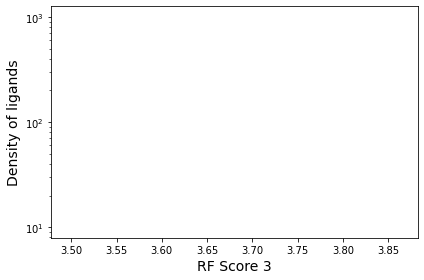

In [ ]:
df_hist['hist_norm'] = df_hist.bincount/df_hist.bincount.sum()/bin_width
ax = df_hist.plot(x="bucket_floor",y="hist_norm",ms=0.5,linewidth=0.75,legend=None)
ax.set_xlabel("RF Score 3",fontsize=14)
ax.set_ylabel("Density of ligands",fontsize=14)
ax.set_yscale('log')
fig = ax.get_figure()
fig.tight_layout()

2D histograms are also possible

In [ ]:
bin_width_x = 0.01
bin_width_y = 0.01
q = """
select floor_x,
       floor_y,
       count(*) as bincount
from (SELECT floor(rf3/{:1.4E})*{:1.4E} AS floor_x, 
             floor(vs_dude_v2/{:1.4E})*{:1.4E} AS floor_y
    FROM mpro_5r84.scores_rank0)
    GROUP BY floor_x, floor_y
    ORDER BY floor_x, floor_y""".format(bin_width_x,bin_width_x,bin_width_y,bin_width_y)
df_hist = client.query(q).to_dataframe()

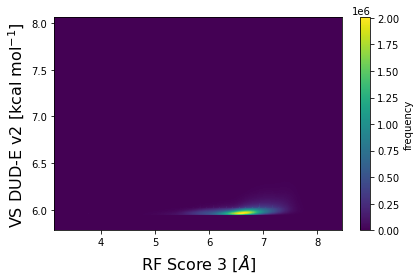

In [ ]:
import numpy as np
x = df_hist.floor_x.values
y = df_hist.floor_y.values
bincount = df_hist.bincount.values
xs = np.unique(x)
ys = np.unique(y)
hist2d_dense = np.zeros((len(xs),len(ys)))
xloc = np.array([np.argwhere(xs==el)[0,0] for el in x])
yloc = np.array([np.argwhere(ys==el)[0,0] for el in y])
hist2d_dense[xloc,yloc] = bincount

import matplotlib.pyplot as plt
fig, ax = plt.subplots()

X,Y = np.meshgrid(xs,ys,indexing='ij')
p = ax.pcolor(X,Y,hist2d_dense,cmap='viridis')
ax.set_xlabel("RF Score 3 [$\AA$]",fontsize=16)
ax.set_ylabel("VS DUD-E v2 [kcal mol$^{-1}$]",fontsize=16)
fig.colorbar(p,label='frequency')
fig.tight_layout()

## Sort the compounds by the standard deviation of the RF2 score between runs

Here, we're interested in finding compounds that dock reproducibly in the same pose, assuming that those compounds are strong binders. We achieve this analysis by comparing the spread of scores within the **nruns** independent dockings for each ligand. In the Gigadocking dataset, **nruns=20** (even though some datasets only contain the top 3 poses). Ligands that always end up in the same pose also have very similar scores between runs and therefore a small standard deviation.


In [ ]:
%%bigquery --project $project_id
SELECT * FROM (SELECT name, AVG(rf2) AS rf2_avg, AVG(vs_dude_v2) as vs_avg, AVG(score) AS score_avg, STDDEV_SAMP(rf2) AS rf2_std
    FROM `cmb-covid19-discovery-collab.mpro_5r84.scores`
    GROUP BY name
    HAVING rf2_avg > 6
    ORDER BY rf2_std
    LIMIT 10000) AS top
INNER JOIN mpro_5r84.scores_rank0 ON top.name = scores_rank0.name
ORDER BY top.rf2_std LIMIT 100

In [ ]:
%%bigquery --project $project_id df
SELECT * FROM mpro_5r84.confs_all
INNER JOIN (
 SELECT * FROM mpro_5r84.scores_rank0
 INNER JOIN
    (SELECT name AS name_inner, AVG(rf2) AS rf2_avg, AVG(vs_dude_v2) as vs_avg, AVG(score) AS score_avg, STDDEV_SAMP(rf2) AS rf2_std
    FROM `cmb-covid19-discovery-collab.mpro_5r84.scores`
    GROUP BY name
    HAVING rf2_avg > 6
    ORDER BY rf2_std
    LIMIT 10000) AS top
  ON top.name_inner = scores_rank0.name
) AS top_outer
ON (confs_all.name = top_outer.name)
#WHERE (confs_all.rank = 0)
ORDER BY top_outer.rf2_std LIMIT 1000

In [ ]:
# download a .zip archive with PDB (use Chrome)
from tqdm.notebook import tqdm
df['pdb'] = df.conf.apply(to_pdb)
pdbs = []
for name,pdb,rank in tqdm(zip(df['name'].values,df['pdb'].values,df['rank'])):
  fn = name+'_rank'+str(rank)+'.pdb'
  with open(fn,'w') as f:
    f.write(pdb)
  pdbs.append(fn)
pdbs = ' '.join(pdbs)
!rm pdb.zip; zip pdb.zip $pdbs
from google.colab import files
files.download('pdb.zip') 


  adding: Z1998288134_3_rank0.pdb (deflated 79%)
  adding: Z1998288134_3_rank3.pdb (deflated 79%)
  adding: Z1998288134_3_rank6.pdb (deflated 79%)
  adding: Z1998288134_3_rank5.pdb (deflated 79%)
  adding: Z1998288134_3_rank14.pdb (deflated 79%)
  adding: Z1998288134_3_rank12.pdb (deflated 79%)
  adding: Z1998288134_3_rank2.pdb (deflated 79%)
  adding: Z1998288134_3_rank18.pdb (deflated 79%)
  adding: Z1998288134_3_rank9.pdb (deflated 79%)
  adding: Z1998288134_3_rank16.pdb (deflated 79%)
  adding: Z1998288134_3_rank17.pdb (deflated 79%)
  adding: Z1998288134_3_rank7.pdb (deflated 79%)
  adding: Z1998288134_3_rank1.pdb (deflated 79%)
  adding: Z1998288134_3_rank8.pdb (deflated 79%)
  adding: Z1998288134_3_rank11.pdb (deflated 79%)
  adding: Z1998288134_3_rank15.pdb (deflated 79%)
  adding: Z1998288134_3_rank13.pdb (deflated 79%)
  adding: Z1998288134_3_rank4.pdb (deflated 79%)
  adding: Z1998288134_3_rank19.pdb (deflated 79%)
  adding: Z1998288134_3_rank10.pdb (deflated 79%)
  adding:

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Histogram of standard deviations

In [ ]:
from google.cloud import bigquery

client = bigquery.Client(project=project_id)
bin_width = 0.001
q = """
SELECT bucket_floor, COUNT(*) as bincount
FROM (
        SELECT floor(rf2_std/{})*{} AS bucket_floor FROM 
        (
          SELECT STDDEV_SAMP(rf2) AS rf2_std
          FROM `cmb-covid19-discovery-collab.mpro_5r84.scores`
          GROUP BY name
          ORDER BY rf2_std
        ) 
      )
GROUP BY bucket_floor
ORDER BY bucket_floor""".format(bin_width,bin_width)
df_hist = client.query(q).to_dataframe()

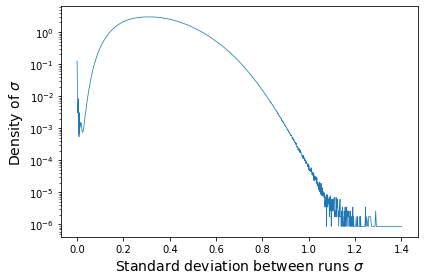

In [ ]:
df_hist['hist_norm'] = df_hist.bincount/df_hist.bincount.sum()/bin_width
ax = df_hist.plot(x="bucket_floor",y="hist_norm",ms=0.5,linewidth=0.75,legend=None)
ax.set_xlabel("Standard deviation between runs $\sigma$",fontsize=14)
ax.set_ylabel("Density of $\sigma$",fontsize=14)
ax.set_yscale('log')
fig = ax.get_figure()
fig.tight_layout()

Here's a version in which we filter out bad (overlapping) compounds by imposing a cut-off on the average score

In [ ]:
from google.cloud import bigquery

client = bigquery.Client(project=project_id)
bin_width = 0.001
q = """
SELECT bucket_floor, COUNT(*) as bincount
FROM (
        SELECT floor(rf2_std/{})*{} AS bucket_floor FROM 
        (
          SELECT STDDEV_SAMP(rf2) AS rf2_std, AVG(rf2) as rf2_avg
          FROM `cmb-covid19-discovery-collab.mpro_5r84.scores`
          GROUP BY name
          HAVING rf2_avg > 6
          ORDER BY rf2_std
        ) 
      )
GROUP BY bucket_floor
ORDER BY bucket_floor""".format(bin_width,bin_width)
df_hist = client.query(q).to_dataframe()

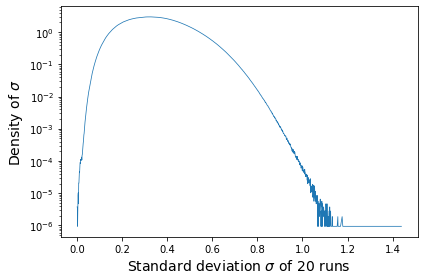

In [ ]:
df_hist['hist_norm'] = df_hist.bincount/df_hist.bincount.sum()/bin_width
ax = df_hist.plot(x="bucket_floor",y="hist_norm",ms=0.5,linewidth=0.75,legend=None)
ax.set_xlabel("Standard deviation $\sigma$ of 20 runs",fontsize=14)
ax.set_ylabel("Density of $\sigma$",fontsize=14)
ax.set_yscale('log')
fig = ax.get_figure()
fig.tight_layout()

Another way to look at the data is to plot standard deviation vs. average

In [ ]:
bin_width_x = 0.001
bin_width_y = 0.01
q = """
select floor_x,
       floor_y,
       count(*) as bincount
from (
    SELECT floor(sigma/{:1.4E})*{:1.4E} AS floor_x, 
           floor(mu/{:1.4E})*{:1.4E} AS floor_y
    FROM 
    (SELECT A.rf2_std AS sigma, A.rf2_avg AS mu FROM
      (
          SELECT name, STDDEV_SAMP(rf2) AS rf2_std, AVG(rf2) as rf2_avg
          FROM `cmb-covid19-discovery-collab.mpro_5r84.scores`
          GROUP BY name
          HAVING rf2_avg > 6
      ) AS A INNER JOIN mpro_5r84.scores_rank0 AS B ON A.name = B.name
    )
)
GROUP BY floor_x, floor_y
ORDER BY floor_x, floor_y""".format(bin_width_x,bin_width_x,bin_width_y,bin_width_y)
df_hist2d = client.query(q).to_dataframe()

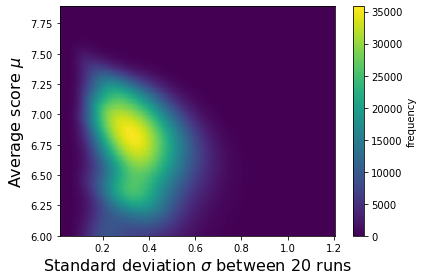

In [ ]:
import numpy as np
x = df_hist2d.floor_x.values
y = df_hist2d.floor_y.values
bincount = df_hist2d.bincount.values
xs = np.unique(x)
ys = np.unique(y)
hist2d_dense = np.zeros((len(xs),len(ys)))
xloc = np.array([np.argwhere(xs==el)[0,0] for el in x])
yloc = np.array([np.argwhere(ys==el)[0,0] for el in y])
hist2d_dense[xloc,yloc] = bincount

import matplotlib.pyplot as plt
fig, ax = plt.subplots()

X,Y = np.meshgrid(xs,ys,indexing='ij')
p = ax.pcolor(X,Y,hist2d_dense,cmap='viridis')
ax.set_xlabel("Standard deviation $\sigma$ between 20 runs",fontsize=16)
ax.set_ylabel("Average score $\mu$",fontsize=16)
fig.colorbar(p,label='frequency')
fig.tight_layout()

Now, bring in the VS score for the average

In [ ]:
bin_width_x = 0.001
bin_width_y = 0.01
q = """
select floor_x,
       floor_y,
       count(*) as bincount
from (
    SELECT floor(sigma/{:1.4E})*{:1.4E} AS floor_x, 
           floor(mu/{:1.4E})*{:1.4E} AS floor_y
    FROM 
    (SELECT A.vs_std AS sigma, a.vs_dude_v2_avg AS mu FROM
      (
          SELECT name, STDDEV_SAMP(vs_dude_v2) AS vs_std,
                       AVG(rf2) AS rf2_avg,
                       AVG(vs_dude_v2) as vs_dude_v2_avg
          FROM `cmb-covid19-discovery-collab.mpro_5r84.scores`
          GROUP BY name
          HAVING rf2_avg > 6
      ) AS A INNER JOIN mpro_5r84.scores_rank0 AS B ON A.name = B.name
    )
)
GROUP BY floor_x, floor_y
ORDER BY floor_x, floor_y""".format(bin_width_x,bin_width_x,bin_width_y,bin_width_y)
df_hist2d_vs = client.query(q).to_dataframe()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()


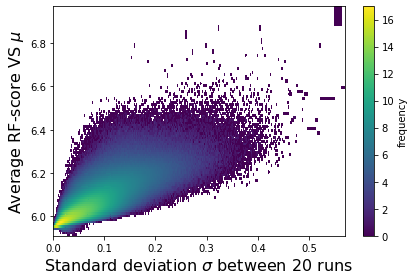

In [ ]:
import numpy as np
x = df_hist2d_vs.floor_x.values
y = df_hist2d_vs.floor_y.values
bincount = df_hist2d_vs.bincount.values
xs = np.unique(x)
ys = np.unique(y)
hist2d_dense = np.zeros((len(xs),len(ys)))
xloc = np.array([np.argwhere(xs==el)[0,0] for el in x])
yloc = np.array([np.argwhere(ys==el)[0,0] for el in y])
hist2d_dense[xloc,yloc] = bincount

import matplotlib.pyplot as plt
fig, ax = plt.subplots()

X,Y = np.meshgrid(xs,ys,indexing='ij')
p = ax.pcolor(X,Y,np.log(hist2d_dense),cmap='viridis')
ax.set_xlabel("Standard deviation $\sigma$ between 20 runs",fontsize=16)
ax.set_ylabel("Average RF-score VS $\mu$",fontsize=16)
fig.colorbar(p,label='frequency')
fig.tight_layout()

Try the same plot with autodock scores

In [ ]:
bin_width_x = 0.01
bin_width_y = 0.01
q = """
select floor_x,
       floor_y,
       count(*) as bincount
from (
    SELECT floor(sigma/{:1.4E})*{:1.4E} AS floor_x, 
           floor(mu/{:1.4E})*{:1.4E} AS floor_y
    FROM 
    (SELECT A.score_std AS sigma, a.score_avg AS mu FROM
      (
          SELECT name, STDDEV_SAMP(score) AS score_std,
                       AVG(score) AS score_avg,
          FROM `cmb-covid19-discovery-collab.mpro_5r84.confs_all`
          GROUP BY name
          HAVING score_avg < 0
      ) AS A INNER JOIN mpro_5r84.scores_rank0 AS B ON A.name = B.name
    )
)
GROUP BY floor_x, floor_y
ORDER BY floor_x, floor_y""".format(bin_width_x,bin_width_x,bin_width_y,bin_width_y)
df_hist2d_ad = client.query(q).to_dataframe()

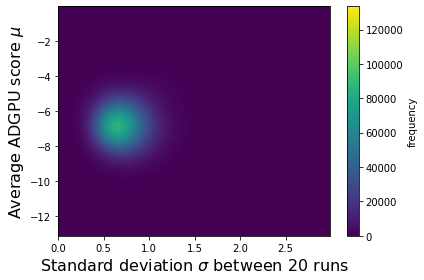

In [ ]:
import numpy as np
x = df_hist2d_ad.floor_x.values
y = df_hist2d_ad.floor_y.values
bincount = df_hist2d_ad.bincount.values
xs = np.unique(x)
ys = np.unique(y)

hist2d_dense = np.zeros((len(xs),len(ys)))
xloc = np.array([np.argwhere(xs==el)[0,0] for el in x])
yloc = np.array([np.argwhere(ys==el)[0,0] for el in y])
hist2d_dense[xloc,yloc] = bincount

import matplotlib.pyplot as plt
fig, ax = plt.subplots()

X,Y = np.meshgrid(xs,ys,indexing='ij')
p = ax.pcolor(X,Y,hist2d_dense,cmap='viridis')
ax.set_xlabel("Standard deviation $\sigma$ between 20 runs",fontsize=16)
ax.set_ylabel("Average ADGPU score $\mu$",fontsize=16)
fig.colorbar(p,label='frequency')
fig.tight_layout()

In [ ]:
!bq show --project_id $project_id mpro_5r84.scores_rank0

Table cmb-covid19-discovery-collab:mpro_5r84.scores_rank0

   Last modified                Schema                Total Rows   Total Bytes    Expiration   Time Partitioning   Clustered Fields   Labels  
 ----------------- --------------------------------- ------------ -------------- ------------ ------------------- ------------------ -------- 
  10 Feb 18:56:32   |- name: string                   1147983152   123807929088                                                               
                    |- vs_dude_v1: float                                                                                                      
                    |- vs_dude_v2: float                                                                                                      
                    |- vs_dude_v3: float                                                                                                      
                    |- vs_dock_v1: float                                           

# The Big Join

In [ ]:
cutoff = 7
q = """
SELECT A.name as name, A.name_first AS enamine_id, A.rf2_avg_5r84, B.rf2_avg_6wqf, C.rf2_avg_7jir, D.rf2_avg_rdrp, E.rf2_avg_nsp15, F.rf2_avg_spike, enamine.*
FROM (SELECT name, SPLIT(name,"_")[OFFSET(0)] as name_first, AVG(rf2) as rf2_avg_5r84 FROM mpro_5r84.scores GROUP BY name HAVING rf2_avg_5r84 > {}) AS A
INNER JOIN (SELECT name, AVG(rf2) as rf2_avg_6wqf FROM mpro_6wqf.scores GROUP BY name HAVING rf2_avg_6wqf > {}) AS B ON A.name = B.name
INNER JOIN (SELECT name, AVG(rf2) as rf2_avg_7jir FROM plpro_7jir.scores_rf2 GROUP BY name HAVING rf2_avg_7jir > {}) AS C ON A.name = C.name
INNER JOIN (SELECT name, AVG(rf2) as rf2_avg_rdrp FROM rdrp.scores_rf2 GROUP BY name HAVING rf2_avg_rdrp > {}) AS D ON A.name = D.name
INNER JOIN (SELECT name, AVG(rf2) as rf2_avg_nsp15 FROM nsp15_6wlc.scores_rf2 GROUP BY name HAVING rf2_avg_nsp15 > {}) AS E ON A.name = E.name
INNER JOIN (SELECT name, AVG(rf2) as rf2_avg_spike FROM spike_6m0j.scores_rf2 GROUP BY name HAVING rf2_avg_spike > {}) AS F ON A.name = F.name
INNER JOIN enamine_2020q1.smiles AS enamine ON A.name_first = enamine.idnumber
""".format(*([cutoff]*6))

from google.cloud import bigquery
client = bigquery.Client(project=project_id)
df = client.query(q).to_dataframe()

In [ ]:
columns = [c for c in df.columns if c.startswith('rf2')]
df[(df[columns] > 7.4).all(axis=1)]

,name,enamine_id,rf2_avg_5r84,rf2_avg_6wqf,rf2_avg_7jir,rf2_avg_rdrp,rf2_avg_nsp15,rf2_avg_spike,smiles,idnumber,reagent1,reagent2,reagent3,reagent4,reaction,MW,HAC,sLogP,HBA,HBD,RotBonds,FSP3,TPSA,QED,PAINS,BRENK,NIH,ZINC,LILLY,lead_like,_350_3_lead_like,fragments,strict_fragments,PPI_modulators,natural_product_like,Type,InChiKey
344,Z904792750_1_T1,Z904792750,7.470462,7.419778,7.443273,7.434628,7.678366,7.639744,CN1C=C(S(=O)(=O)NC(=O)C2=C(S(=O)(=O)N3CCSCC3)C...,Z904792750,2014142,2032511,NaN,None,2740,436.562,26,0.338,9,1,5,0.385,118.44,0.718,None,None,None,None,None,True,None,None,None,True,None,S,FSENLBVBXXTELO-UHFFFAOYSA-N
5071,Z1438076742_1_T1,Z1438076742,7.584597,7.522652,7.563805,7.842281,7.750629,7.516381,CCS(=O)(=O)NCCNS(=O)(=O)C1=CC=C(C2=CSC(C)=N2)S1,Z1438076742,2113473,201525,NaN,None,40,395.553,23,1.398,7,2,8,0.417,105.23,0.657,None,True,None,None,None,True,None,None,None,None,None,S,BBXYGDVFRHEXNF-UHFFFAOYSA-N
5250,Z746625760_1_T1,Z746625760,7.565671,7.566727,7.504206,7.438331,7.699931,7.485150,CC1=C(SCC(N)=O)SC(NC(=O)CSC2CCS(=O)(=O)C2)=N1,Z746625760,249524,36837,NaN,None,22,395.553,23,0.888,8,2,7,0.583,119.22,0.658,None,None,None,None,None,True,None,None,None,None,None,S,IBJIGGCXJYDKQP-UHFFFAOYSA-N
5256,Z1066168224_1_T1,Z1066168224,7.446873,7.454228,7.493304,7.472150,7.734466,7.453044,CC1=C(SCC#N)SC(NS(=O)(=O)C2=CC=C(S(C)(=O)=O)C=...,Z1066168224,249510,46666,NaN,None,232682,403.532,24,2.272,8,1,6,0.231,116.99,0.735,None,None,None,None,True,True,None,None,None,None,None,S,XYLHXBKOKMSIQR-UHFFFAOYSA-N
7524,Z2073689057_1_T1,Z2073689057,7.519921,7.559044,7.488400,7.660763,7.812794,7.489850,CC1=C(CCS(=O)(=O)NC(=O)CC2=C(C)N=C(SC(F)F)S2)S...,Z2073689057,6118425,8921200,NaN,None,2740,427.545,25,2.762,8,1,8,0.462,89.02,0.652,None,None,None,None,None,True,None,None,None,None,None,S,UNDURPZBWGJDET-UHFFFAOYSA-N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162780,Z192727784_1_T1,Z192727784,7.467482,7.447444,7.489680,7.430170,7.536784,7.460753,O=C(NC1=NC2=CC=C(SC(F)F)C=C2S1)C1=C(S(=O)(=O)N...,Z192727784,2055,40718,NaN,None,11,491.588,30,3.946,8,1,6,0.294,88.60,0.526,None,None,None,None,None,None,None,None,None,None,None,S,MTRIHFJVWLFMLJ-UHFFFAOYSA-N
163152,Z1708223619_1_T1,Z1708223619,7.496944,7.529536,7.576908,7.507009,7.627827,7.455888,CCC1=CC=C(C2=CSC(NS(=O)(=O)C3=CSC([N+](=O)[O-]...,Z1708223619,33004,3109166,NaN,None,232682,401.516,24,4.205,8,1,6,0.154,102.20,0.492,True,True,None,None,None,None,None,None,None,None,None,S,BIGSRNTXGSQJJW-UHFFFAOYSA-N
163384,Z351271448_1_T1,Z351271448,7.406166,7.426742,7.438757,7.651307,7.480210,7.474512,O=S(CC1=CSC(C2=CC=CS2)=N1)C1=CC=C(S(=O)(=O)N2C...,Z351271448,32646,17193,NaN,None,265282,455.608,28,2.595,8,0,6,0.294,89.46,0.568,None,None,None,None,None,True,None,None,None,None,None,S,SQAFCQOKGGYRHN-UHFFFAOYSA-N
163387,Z351271448_2_T2,Z351271448,7.408597,7.428788,7.501588,7.546191,7.481435,7.425396,O=S(CC1=CSC(C2=CC=CS2)=N1)C1=CC=C(S(=O)(=O)N2C...,Z351271448,32646,17193,NaN,None,265282,455.608,28,2.595,8,0,6,0.294,89.46,0.568,None,None,None,None,None,True,None,None,None,None,None,S,SQAFCQOKGGYRHN-UHFFFAOYSA-N


## Top n-tile list per target

- Mpro 5R84

In [39]:
ntile = 999
num_ntiles = ntile+1
tab = "mpro_5r84.scores"
q = f"""

SELECT A.name as name, A.name_first AS enamine_id, rf2_avg, vs_avg, enamine.*
FROM (
  WITH ntile AS (
    SELECT APPROX_QUANTILES(rf2_avg, {num_ntiles})[OFFSET({ntile})] AS rf2_ntile,
          APPROX_QUANTILES(vs_avg, {num_ntiles})[OFFSET({ntile})] AS vs_ntile
    FROM (SELECT AVG(rf2) as rf2_avg, AVG(vs_dude_v2) as vs_avg FROM {tab} GROUP BY name)
  )
  SELECT SPLIT(name,"_")[OFFSET(0)] as name_first, * FROM
    (SELECT name, AVG(rf2) as rf2_avg, AVG(vs_dude_v2) as vs_avg
      FROM {tab}
      GROUP BY name
    ) AS B
    CROSS JOIN ntile
    WHERE B.rf2_avg >= ntile.rf2_ntile AND
          B.vs_avg >= ntile.vs_ntile
) AS A
INNER JOIN enamine_2020q1.smiles AS enamine ON A.name_first = enamine.idnumber
"""


from google.cloud import bigquery
client = bigquery.Client(project=project_id)
df = client.query(q).to_dataframe()

In [41]:
df

,name,enamine_id,rf2_avg,vs_avg,smiles,idnumber,reagent1,reagent2,reagent3,reagent4,reaction,MW,HAC,sLogP,HBA,HBD,RotBonds,FSP3,TPSA,QED,PAINS,BRENK,NIH,ZINC,LILLY,lead_like,_350_3_lead_like,fragments,strict_fragments,PPI_modulators,natural_product_like,Type,InChiKey
0,Z1952071581_2_T1,Z1952071581,7.541451,6.225972,CC(CN(C(=O)C1=C2C=NC=CN2N=C1)C1=CC=CC=C1)NC(=O...,Z1952071581,2786167,3610684,NaN,None,11,440.467,33,2.237,8,1,6,0.130,109.79,0.434,None,None,None,None,None,None,None,None,None,None,None,S,ZEYOJOIRIRTRSY-UHFFFAOYSA-N
1,Z1608129600_1_T1,Z1608129600,7.556409,6.171008,CC1=CC=C(N2C=NN=N2)C=C1NC(=O)NC1CCCOC2=CC(F)=C...,Z1608129600,11929127,2020772,NaN,None,487,382.399,28,3.145,6,2,3,0.263,93.96,0.726,None,None,None,None,None,True,None,None,None,None,None,S,QMDHEGBGWODNOY-UHFFFAOYSA-N
2,Z1602155829_1_T1,Z1602155829,7.588454,6.169903,COC1=CC=CC(CC(C(=O)N(C)C2=CC=C(F)C(Cl)=C2)N2N=...,Z1602155829,11927104,1135281,NaN,None,11,403.845,28,3.229,6,0,6,0.263,73.14,0.631,None,None,None,None,None,True,None,None,None,None,None,S,PFGJVACPTMZFAH-UHFFFAOYSA-N
3,Z2090986382_1_T1,Z2090986382,7.531055,6.169093,CC1=NN=NN1C(=CC1=CC=C(F)C=C1)C(=O)NCC1=C2C=CC=...,Z2090986382,11929637,45402,NaN,None,22,377.383,28,2.083,7,1,5,0.105,90.00,0.538,None,True,None,None,True,True,None,None,None,None,None,S,LITTYFJQLRRXQD-UHFFFAOYSA-N
4,Z1833768807_1_T6,Z1833768807,7.564418,6.167781,COC(=O)C1=N[NH]C(C2=CC=CC=C2CNC(=O)C2=CC3=C(C=...,Z1833768807,11923293,12500140,NaN,None,22,394.366,29,2.204,6,3,5,0.105,125.65,0.446,None,None,None,None,None,True,None,None,None,None,None,S,SGXXOOHQYSAHMN-UHFFFAOYSA-N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17025,Z1023722616_1_T1,Z1023722616,7.631934,6.289768,O=C(NCCC(=O)N1CCN(C2=NC=CC=N2)CC1)C1=C(C(F)(F)...,Z1023722616,2101793,2078504,NaN,None,22,492.437,35,1.684,8,1,6,0.333,109.14,0.522,None,None,None,None,None,None,None,None,None,None,None,S,RYEVOHWVAUKOCI-UHFFFAOYSA-N
17026,Z1161214541_1_T1,Z1161214541,7.529291,6.209270,CC1=C(C(=O)NCCC(=O)N2CCN(C3=NC=CC=N3)CC2)N=NN1...,Z1161214541,2101793,2783989,NaN,None,22,471.525,35,1.383,9,1,6,0.292,122.03,0.448,None,None,None,None,None,None,None,None,None,None,None,S,JDOODAOJHIILBQ-UHFFFAOYSA-N
17027,Z1088492438_2_T1,Z1088492438,7.540047,6.239353,CC1=NN=NN1C1=CC(NC(=O)N2CCCC(CN3CCN(C4=CC=CC=N...,Z1088492438,2099524,2049488,NaN,None,2430,479.564,35,2.571,8,1,5,0.458,95.31,0.601,None,None,None,None,None,None,None,None,None,True,None,S,FZSLTLHFSJJBLC-UHFFFAOYSA-N
17028,Z1027969308_1_T1,Z1027969308,7.532519,6.214798,COC1=CC=C(NC(=O)N2CCN(C(C)C(=O)NC3=CC=CC(F)=C3...,Z1027969308,2099525,526009,NaN,None,2430,482.520,35,2.295,8,2,6,0.348,117.51,0.554,None,None,None,None,True,None,None,None,None,None,None,S,GNWGJXVJKDJYTJ-UHFFFAOYSA-N


In [42]:
df.to_gbq('mpro_5r84.top_0001',project_id=project_id,if_exists='replace')

1it [00:07,  7.41s/it]


In [43]:
ntile = 999
num_ntiles = ntile+1
tab = "mpro_6wqf.scores"
q = f"""

SELECT A.name as name, A.name_first AS enamine_id, rf2_avg, vs_avg, enamine.*
FROM (
  WITH ntile AS (
    SELECT APPROX_QUANTILES(rf2_avg, {num_ntiles})[OFFSET({ntile})] AS rf2_ntile,
          APPROX_QUANTILES(vs_avg, {num_ntiles})[OFFSET({ntile})] AS vs_ntile
    FROM (SELECT AVG(rf2) as rf2_avg, AVG(vs_dude_v2) as vs_avg FROM {tab} GROUP BY name)
  )
  SELECT SPLIT(name,"_")[OFFSET(0)] as name_first, * FROM
    (SELECT name, AVG(rf2) as rf2_avg, AVG(vs_dude_v2) as vs_avg
      FROM {tab}
      GROUP BY name
    ) AS B
    CROSS JOIN ntile
    WHERE B.rf2_avg >= ntile.rf2_ntile AND
          B.vs_avg >= ntile.vs_ntile
) AS A
INNER JOIN enamine_2020q1.smiles AS enamine ON A.name_first = enamine.idnumber
"""


from google.cloud import bigquery
client = bigquery.Client(project=project_id)
df = client.query(q).to_dataframe()

In [44]:
df

,name,enamine_id,rf2_avg,vs_avg,smiles,idnumber,reagent1,reagent2,reagent3,reagent4,reaction,MW,HAC,sLogP,HBA,HBD,RotBonds,FSP3,TPSA,QED,PAINS,BRENK,NIH,ZINC,LILLY,lead_like,_350_3_lead_like,fragments,strict_fragments,PPI_modulators,natural_product_like,Type,InChiKey
0,Z1337023943_4_T4,Z1337023943,7.384624,6.186021,O=C(NCC1CCCC1NC(=O)C1=CC(F)=CC2=C1N=C[NH]2)C1=...,Z1337023943,2106543,2013961,NaN,None,22,438.438,32,3.046,4,4,5,0.273,115.56,0.383,None,None,None,None,None,None,None,None,None,None,None,S,BOSCEGQNVNANIP-UHFFFAOYSA-N
1,Z1495052324_15_T1,Z1495052324,7.393722,6.131027,CC1=NN=C2CCC(C(=O)NCC3CCCC3NC(=O)C3CCC4=NN=C(C...,Z1495052324,2106543,2014580,NaN,None,22,440.552,32,0.713,8,2,5,0.727,119.62,0.707,None,None,None,None,None,None,None,None,None,True,None,S,KITLUKQUOCUMSJ-UHFFFAOYSA-N
2,Z1669161724_4_T1,Z1669161724,7.441037,6.168622,CN1N=NC2=CC=C(C(=O)NCC3CCCC3NC(=O)C3=CC=C4N=NN...,Z1669161724,2106543,3768876,NaN,None,22,432.488,32,1.578,8,2,5,0.364,119.62,0.494,None,None,None,None,None,None,None,None,None,True,None,S,LHANPXKNEPXVHU-UHFFFAOYSA-N
3,Z1493323396_2_T1,Z1493323396,7.451289,6.132939,COC1=CC=CC=C1N1CCC(NC(=O)CC2=C(C)N(C3=CN=CC4=N...,Z1493323396,3847305,10990201,NaN,None,22,447.503,33,1.268,10,1,6,0.364,115.36,0.470,None,None,None,None,None,None,None,None,None,True,None,S,KFFJVYBNUAUADM-UHFFFAOYSA-N
4,Z2228930519_2,Z2228930519,7.382402,6.130756,CC1=NN=NN1C(=CC1=CC=C(F)C=C1)C(=O)NC[C@@H]1C[C...,Z2228930519,4866172,45402,NaN,None,22,448.474,32,2.582,7,1,5,0.476,102.24,0.706,None,True,None,None,True,True,None,None,None,True,None,S,IITYDPHVKVKMHV-IRXDYDNUSA-N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20952,Z384095618_1_T1,Z384095618,7.465698,6.221978,CCC(NC(=O)C1CCN(C2=NN3C(C(F)(F)F)=NN=C3C=C2)CC...,Z384095618,143018,41980,NaN,None,527,498.456,35,4.228,7,1,7,0.455,84.65,0.491,None,None,None,None,None,None,None,None,None,None,None,S,UWFPYLTVXCFHFL-UHFFFAOYSA-N
20953,Z453946510_2_T1,Z453946510,7.409274,6.166749,CC1=NN=NN1C(=CC1=CC=C(F)C=C1)C(=O)N1CCN(C(=O)C...,Z453946510,139266,45402,NaN,None,22,488.445,35,3.122,6,0,4,0.261,84.22,0.416,None,True,None,None,True,None,None,None,None,None,None,S,JSFMSNSDSQMTKW-UHFFFAOYSA-N
20954,Z512229134_2_T2,Z512229134,7.440215,6.179481,CC(NC(=O)NNC1=CC=C(N2C=CC=N2)N=N1)C1=CC=CC(NC(...,Z512229134,142426,1000239,NaN,None,2708,474.500,35,3.370,7,4,8,0.125,125.86,0.290,None,True,None,None,True,None,None,None,None,None,None,S,NZBQNKHOEHWBIS-UHFFFAOYSA-N
20955,Z512229134_1_T2,Z512229134,7.381580,6.144878,CC(NC(=O)NNC1=CC=C(N2C=CC=N2)N=N1)C1=CC=CC(NC(...,Z512229134,142426,1000239,NaN,None,2708,474.500,35,3.370,7,4,8,0.125,125.86,0.290,None,True,None,None,True,None,None,None,None,None,None,S,NZBQNKHOEHWBIS-UHFFFAOYSA-N


In [45]:
df.to_gbq('mpro_6wqf.top_0001',project_id=project_id,if_exists='replace')

1it [00:08,  8.03s/it]


In [48]:
ntile = 999
num_ntiles = ntile+1
tab = "plpro_7jir.scores"
q = f"""

SELECT A.name as name, A.name_first AS enamine_id, rf3_avg, vs_avg, enamine.*
FROM (
  WITH ntile AS (
    SELECT APPROX_QUANTILES(rf3_avg, {num_ntiles})[OFFSET({ntile})] AS rf3_ntile,
          APPROX_QUANTILES(vs_avg, {num_ntiles})[OFFSET({ntile})] AS vs_ntile
    FROM (SELECT AVG(rf3) as rf3_avg, AVG(vs_dude_v2) as vs_avg FROM {tab} GROUP BY name)
  )
  SELECT SPLIT(name,"_")[OFFSET(0)] as name_first, * FROM
    (SELECT name, AVG(rf3) as rf3_avg, AVG(vs_dude_v2) as vs_avg
      FROM {tab}
      GROUP BY name
    ) AS B
    CROSS JOIN ntile
    WHERE B.rf3_avg >= ntile.rf3_ntile AND
          B.vs_avg >= ntile.vs_ntile
) AS A
INNER JOIN enamine_2020q1.smiles AS enamine ON A.name_first = enamine.idnumber
"""


from google.cloud import bigquery
client = bigquery.Client(project=project_id)
df = client.query(q).to_dataframe()

In [50]:
df

,name,enamine_id,rf3_avg,vs_avg,smiles,idnumber,reagent1,reagent2,reagent3,reagent4,reaction,MW,HAC,sLogP,HBA,HBD,RotBonds,FSP3,TPSA,QED,PAINS,BRENK,NIH,ZINC,LILLY,lead_like,_350_3_lead_like,fragments,strict_fragments,PPI_modulators,natural_product_like,Type,InChiKey
0,Z994049238_1_T3,Z994049238,7.784366,6.343651,O=C(NC1=CC=C(C2=NOC(=O)[NH]2)C=C1)C1=CC=C2C(=O...,Z994049238,8680859,13367,NaN,None,527,440.415,33,3.078,6,2,5,0.042,125.37,0.460,None,True,None,None,True,None,None,None,None,None,None,S,MEALOZYKDMREPC-UHFFFAOYSA-N
1,Z1488517506_2_T1,Z1488517506,7.718129,6.301078,CC(C1=CC=NC=C1)N1CCC(NC(=O)C2=CC(C3=CC=C4OCCC4...,Z1488517506,8932545,9180823,NaN,None,527,418.497,31,3.627,6,1,5,0.375,80.49,0.682,None,None,None,None,None,None,None,None,None,True,None,S,HJYAAYGGCOXUHA-UHFFFAOYSA-N
2,Z1488522093_1_T1,Z1488522093,7.764102,6.345015,CC(C1=CC=NC=C1)N1CCC(NC(=O)C2=NN(C3=CC=CC(C(F)...,Z1488522093,8932545,3566371,NaN,None,22,443.473,32,4.242,5,1,5,0.348,63.05,0.641,None,None,None,None,None,None,None,None,None,None,None,S,LLRMLIUUUUXWIH-UHFFFAOYSA-N
3,Z1532995824_1_T1,Z1532995824,7.795690,6.303982,CC(=NNC1=NC2=CC=CC=C2C(=O)[NH]1)C1=CC=C(OC2=CC...,Z1532995824,2996158,3990117,NaN,None,4,414.421,31,4.250,6,3,6,0.043,116.67,0.321,None,True,None,None,True,None,None,None,None,None,None,S,CEHVFLSSQGSLAZ-UHFFFAOYSA-N
4,Z1532995824_2_T1,Z1532995824,7.750852,6.309643,CC(=NNC1=NC2=CC=CC=C2C(=O)[NH]1)C1=CC=C(OC2=CC...,Z1532995824,2996158,3990117,NaN,None,4,414.421,31,4.250,6,3,6,0.043,116.67,0.321,None,True,None,None,True,None,None,None,None,None,None,S,CEHVFLSSQGSLAZ-UHFFFAOYSA-N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5445,Z1553194729_2_T2,Z1553194729,7.699319,6.300529,O=C(CN1C(=O)NC2(CCC3=CC=CC=C32)C1=O)OCC1=CC=C(...,Z1553194729,13055,11906663,NaN,None,1458,444.447,33,2.706,7,1,6,0.208,110.72,0.460,None,True,None,None,True,None,None,None,None,None,None,S,UEBRQXZQSKOYTE-UHFFFAOYSA-N
5446,Z145422656_1_T1,Z145422656,7.674230,6.309612,CCOC1=CC=C(C(=O)NNC(=O)C2=CC(C3=CC=CC=C3)=NC3=...,Z145422656,13595,31222,NaN,None,22,473.533,35,4.161,7,2,7,0.231,107.37,0.390,None,True,None,None,True,None,None,None,None,None,None,S,HZKIEAKGABRLGC-UHFFFAOYSA-N
5447,Z136142886_1_T1,Z136142886,7.704059,6.298323,CCOC1=CC=C(C(=O)NNC(=O)C2=CC=C(N3C(C)=NC4=CC=C...,Z136142886,13595,32051,NaN,None,22,472.501,35,3.176,7,2,6,0.154,111.55,0.417,None,True,None,None,True,None,None,None,None,None,None,S,FUBWELYHVCWORI-UHFFFAOYSA-N
5448,Z18184429_1_T2,Z18184429,7.697721,6.403757,O=C(CN1C(=O)NC2(CCC3=CC=CC=C32)C1=O)OCC(=O)N1C...,Z18184429,13055,221477,NaN,None,1458,480.496,35,1.411,6,1,5,0.360,99.26,0.513,None,True,None,None,True,None,None,None,None,True,None,S,JBCRUGQQYZUXNT-UHFFFAOYSA-N


In [51]:
df.to_gbq('plpro.top_001',project_id=project_id,if_exists='replace')

1it [00:03,  3.97s/it]


In [52]:
ntile = 999
num_ntiles = ntile+1
tab = "rdrp.scores"
q = f"""

SELECT A.name as name, A.name_first AS enamine_id, rf3_avg, vs_avg, enamine.*
FROM (
  WITH ntile AS (
    SELECT APPROX_QUANTILES(rf3_avg, {num_ntiles})[OFFSET({ntile})] AS rf3_ntile,
          APPROX_QUANTILES(vs_avg, {num_ntiles})[OFFSET({ntile})] AS vs_ntile
    FROM (SELECT AVG(rf3) as rf3_avg, AVG(vs_dude_v2) as vs_avg FROM {tab} GROUP BY name)
  )
  SELECT SPLIT(name,"_")[OFFSET(0)] as name_first, * FROM
    (SELECT name, AVG(rf3) as rf3_avg, AVG(vs_dude_v2) as vs_avg
      FROM {tab}
      GROUP BY name
    ) AS B
    CROSS JOIN ntile
    WHERE B.rf3_avg >= ntile.rf3_ntile AND
          B.vs_avg >= ntile.vs_ntile
) AS A
INNER JOIN enamine_2020q1.smiles AS enamine ON A.name_first = enamine.idnumber
"""


from google.cloud import bigquery
client = bigquery.Client(project=project_id)
df = client.query(q).to_dataframe()

In [53]:
df

,name,enamine_id,rf3_avg,vs_avg,smiles,idnumber,reagent1,reagent2,reagent3,reagent4,reaction,MW,HAC,sLogP,HBA,HBD,RotBonds,FSP3,TPSA,QED,PAINS,BRENK,NIH,ZINC,LILLY,lead_like,_350_3_lead_like,fragments,strict_fragments,PPI_modulators,natural_product_like,Type,InChiKey
0,Z1953144822_2_T1,Z1953144822,7.523957,6.214590,CC1=NN(C2=CC=CC=C2)C2=NC=C(C(=O)NCC3CC(C(N)=O)...,Z1953144822,15329480,73594,NaN,None,22,378.392,28,1.089,7,2,5,0.211,124.49,0.688,None,None,None,None,True,True,None,None,None,None,None,S,ANRXRLFJJIJUQM-UHFFFAOYSA-N
1,Z1098709147_2_T2,Z1098709147,7.600018,6.215306,O=C(CC1SC(N2CCCCC2)=NC1=O)NC1=CC(C(=O)NC2=N[NH...,Z1098709147,2223479,16034,NaN,None,22,494.552,35,3.767,6,3,5,0.292,119.55,0.497,None,None,None,None,True,None,None,None,None,None,None,S,KJOBWFGVNJTIFP-UHFFFAOYSA-N
2,Z1137451163_1_T3,Z1137451163,7.518023,6.339822,O=C(CCCCCC(=O)NC1=N[NH]C2=CC=C(F)C=C12)NC1=N[N...,Z1137451163,2223479,455,NaN,None,22,426.427,31,4.245,4,4,8,0.238,115.56,0.315,None,True,None,None,None,None,None,None,None,None,None,S,ZQWYUKZKJSZXQO-UHFFFAOYSA-N
3,Z2007555877_2_T2,Z2007555877,7.706364,6.230524,CN1C(C2=N[NH]C(=O)C3=CC=CC=C23)=NN=C1N1CCC(NC(...,Z2007555877,12,2057434,8928.0,None,270942,448.462,33,2.258,7,3,4,0.227,120.83,0.440,None,None,None,None,None,None,None,None,None,None,None,S,UZUCWTBMLCAANL-UHFFFAOYSA-N
4,Z2007899951_1,Z2007899951,7.538650,6.240991,CC1=CC=C(NC(=O)NCC2CCCN(C3=NN=C(C(=O)NC4=CC=CC...,Z2007899951,12,2061506,3123162.0,None,270942,448.531,33,2.809,7,3,6,0.348,117.07,0.534,None,None,None,None,None,True,None,None,None,None,None,S,ZUJWUCBCRWJQCV-UHFFFAOYSA-N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6537,Z758992822_1_T1,Z758992822,7.531969,6.271618,CC1=CC(C)=C(C2=N[NH]C(NC(=O)C3CCN(C4=NN5C(C(F)...,Z758992822,8072,41980,NaN,None,527,498.513,36,4.314,7,2,4,0.375,104.10,0.435,None,None,None,None,None,None,None,None,None,None,None,S,AIYAKFQZGQWLNF-UHFFFAOYSA-N
6538,Z333045316_1_T1,Z333045316,7.563557,6.296688,O=C(C1=CC(NS(=O)(=O)C2=CC=C3N=NN(O)C3=C2)=CC=C...,Z333045316,8437,13949,NaN,None,527,475.490,34,2.479,9,2,4,0.091,135.24,0.381,None,True,None,None,True,None,None,None,None,None,None,S,IISQVKXQIBZKBC-UHFFFAOYSA-N
6539,Z295741368_1_T1,Z295741368,7.587759,6.233539,O=C(CC1SC(N2CCCC2)=NC1=O)NC1=CC=C(C(=O)N2CCN3C...,Z295741368,8437,16464,NaN,None,527,488.573,35,3.119,7,1,4,0.320,99.90,0.606,None,None,None,None,True,None,None,None,None,None,None,S,RXOKUZLHNRMHQN-UHFFFAOYSA-N
6540,Z365247662_1_T1,Z365247662,7.552356,6.236124,CC1=CC(C(=O)N2CCN(S(=O)(=O)C3=CC=C4C=CC=CC4=C3...,Z365247662,8116,126743,NaN,None,22,462.535,33,2.271,7,0,4,0.217,101.29,0.461,None,None,None,None,None,None,None,None,None,None,None,S,ABQCXJBQYRMMLN-UHFFFAOYSA-N


In [54]:
df.to_gbq('rdrp.top_001',project_id=project_id,if_exists='replace')

1it [00:05,  5.01s/it]


In [55]:
ntile = 999
num_ntiles = ntile+1
tab = "nsp15_6wlc.scores_rf2"
q = f"""

SELECT A.name as name, A.name_first AS enamine_id, rf2_avg, enamine.*
FROM (
  WITH ntile AS (
    SELECT APPROX_QUANTILES(rf2_avg, {num_ntiles})[OFFSET({ntile})] AS rf2_ntile
    FROM (SELECT AVG(rf2) as rf2_avg FROM {tab} GROUP BY name)
  )
  SELECT SPLIT(name,"_")[OFFSET(0)] as name_first, * FROM
    (SELECT name, AVG(rf2) as rf2_avg
      FROM {tab}
      GROUP BY name
    ) AS B
    CROSS JOIN ntile
    WHERE B.rf2_avg >= ntile.rf2_ntile
) AS A
INNER JOIN enamine_2020q1.smiles AS enamine ON A.name_first = enamine.idnumber
"""


from google.cloud import bigquery
client = bigquery.Client(project=project_id)
df = client.query(q).to_dataframe()

In [56]:
df

,name,enamine_id,rf2_avg,smiles,idnumber,reagent1,reagent2,reagent3,reagent4,reaction,MW,HAC,sLogP,HBA,HBD,RotBonds,FSP3,TPSA,QED,PAINS,BRENK,NIH,ZINC,LILLY,lead_like,_350_3_lead_like,fragments,strict_fragments,PPI_modulators,natural_product_like,Type,InChiKey
0,Z1579504842_1_T2,Z1579504842,7.512038,CC1=CC(C2=NC(C(=O)OCC(=O)NC3=CC(N4N=NN=C4C)=CC...,Z1579504842,8441434,10011131,NaN,None,1458,449.446,33,2.912,8,2,6,0.182,127.68,0.433,None,None,None,None,True,True,None,None,None,None,None,S,WHOYOEVQABUZRP-UHFFFAOYSA-N
1,Z1579504842_1_T1,Z1579504842,7.446473,CC1=CC(C2=NC(C(=O)OCC(=O)NC3=CC(N4N=NN=C4C)=CC...,Z1579504842,8441434,10011131,NaN,None,1458,449.446,33,2.912,8,2,6,0.182,127.68,0.433,None,None,None,None,True,True,None,None,None,None,None,S,WHOYOEVQABUZRP-UHFFFAOYSA-N
2,Z1453991683_1_T1,Z1453991683,7.471403,CC1=CC=C(N2N=CC=C2NC(=O)C2=CC3=C(S2)N(C2=CC=C(...,Z1453991683,8446174,2119,NaN,None,11,449.927,31,4.585,8,1,4,0.095,90.52,0.433,None,None,None,None,None,None,None,None,None,None,None,S,RMROSSBBEKWFGT-UHFFFAOYSA-N
3,Z1453991185_1_T1,Z1453991185,7.431835,CC1=CC=C(N2N=CC=C2NC(=O)C2=CC3=C(S2)N(C2=CC=CC...,Z1453991185,8446174,2184,NaN,None,11,449.927,31,4.585,8,1,4,0.095,90.52,0.433,None,None,None,None,None,None,None,None,None,None,None,S,UGCFKYRLZVPWCA-UHFFFAOYSA-N
4,Z1453991681_1_T1,Z1453991681,7.439115,CC1=CC=C(N2N=CC=C2NC(=O)C2=CC=C(N3CCC(C)CC3)C(...,Z1453991681,8446174,4028,NaN,None,11,421.461,31,3.368,8,1,5,0.333,119.08,0.495,None,True,None,None,True,True,None,None,None,None,None,S,CYEQGEBMDUVOMQ-UHFFFAOYSA-N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
405542,Z807244792_1_T1,Z807244792,7.430537,N#CCOC1=CC(NC(=O)NCC2=CC=C(N3CCN(C4=NC=CC=N4)C...,Z807244792,159908,2016271,NaN,None,2430,461.501,34,3.166,7,2,7,0.250,106.41,0.557,None,None,None,None,True,None,None,None,None,None,None,S,NGTNGQZKJOIABO-UHFFFAOYSA-N
405543,Z604330642_1_T1,Z604330642,7.439504,COC1=CC=C(NC(=O)N2CCN(C3=NC=CC=N3)CC2)C=C1NC(=...,Z604330642,162032,2027,NaN,None,2430,484.919,34,3.884,6,2,5,0.217,99.69,0.570,None,None,None,None,True,None,None,None,None,None,None,S,VVBXRCAFZHVVNA-UHFFFAOYSA-N
405544,Z604336072_1_T1,Z604336072,7.447403,COC1=CC=C(NC(=O)NCC2=NN=C3CCCCCN32)C=C1NC(=O)C...,Z604336072,162032,32027,NaN,None,2430,486.935,34,4.380,6,3,6,0.304,110.17,0.479,None,None,None,None,True,None,None,None,None,None,None,S,HDHVHXDLVIXGJL-UHFFFAOYSA-N
405545,Z604339488_2_T1,Z604339488,7.491415,COC1=CC=C(NC(=O)NC(C)C2=NN=C3C=CC=CN23)C=C1NC(...,Z604339488,162032,221762,NaN,None,2430,482.903,34,4.665,6,3,6,0.130,109.65,0.370,None,None,None,None,True,None,None,None,None,None,None,S,DRTVKIZRMAFTDP-UHFFFAOYSA-N


In [58]:
df.to_gbq('nsp15_6wlc.top_001',project_id=project_id,if_exists='replace')

1it [00:49, 49.60s/it]


In [60]:
ntile = 999
num_ntiles = ntile+1
tab = "spike_6m0j.scores_rf2"
q = f"""

SELECT A.name as name, A.name_first AS enamine_id, rf2_avg, enamine.*
FROM (
  WITH ntile AS (
    SELECT APPROX_QUANTILES(rf2_avg, {num_ntiles})[OFFSET({ntile})] AS rf2_ntile
    FROM (SELECT AVG(rf2) as rf2_avg FROM {tab} GROUP BY name)
  )
  SELECT SPLIT(name,"_")[OFFSET(0)] as name_first, * FROM
    (SELECT name, AVG(rf2) as rf2_avg
      FROM {tab}
      GROUP BY name
    ) AS B
    CROSS JOIN ntile
    WHERE B.rf2_avg >= ntile.rf2_ntile
) AS A
INNER JOIN enamine_2020q1.smiles AS enamine ON A.name_first = enamine.idnumber
"""


from google.cloud import bigquery
client = bigquery.Client(project=project_id)
df = client.query(q).to_dataframe()

In [61]:
df

,name,enamine_id,rf2_avg,smiles,idnumber,reagent1,reagent2,reagent3,reagent4,reaction,MW,HAC,sLogP,HBA,HBD,RotBonds,FSP3,TPSA,QED,PAINS,BRENK,NIH,ZINC,LILLY,lead_like,_350_3_lead_like,fragments,strict_fragments,PPI_modulators,natural_product_like,Type,InChiKey
0,Z2773204134_1_T1,Z2773204134,7.056219,CC1(C)CN(S(=O)(=O)N=S2(=O)CCCC2)CCN1,Z2773204134,7755271,19205651,NaN,None,270084,295.430,18,0.177,4,1,2,1.000,78.84,0.788,None,None,None,None,None,True,True,None,None,None,None,M,YIHVGHQNEDBCGF-UHFFFAOYSA-N
1,Z1902975195_69_T1,Z1902975195,7.068010,COC(=O)C1=CC=C(N2C=C(C)C=N2)C(NC(=O)NCC2(O)C3C...,Z1902975195,7762247,17435054,NaN,None,2430,448.523,33,2.598,6,3,5,0.560,105.48,0.610,None,None,None,None,True,None,None,None,None,None,None,S,LIFNVUASKAXRDM-UHFFFAOYSA-N
2,Z2443909871_2_T1,Z2443909871,7.163374,CS(=O)(=O)C1=CC=C(S(=O)(=O)NC2CCCNCC2)C=N1,Z2443909871,7752836,9983764,NaN,None,270084,333.435,21,-0.094,6,2,4,0.583,105.23,0.797,None,None,None,None,None,True,True,None,None,None,None,S,QFKHUTPBNWFFST-UHFFFAOYSA-N
3,Z2592426083_1_T1,Z2592426083,7.265567,CC1(C)CN(S(=O)(=O)C2=CC=C(S(N)(=O)=O)C=C2)CCN1,Z2592426083,7755271,38044,NaN,None,270084,333.435,21,-0.293,5,2,3,0.500,109.57,0.790,None,None,None,None,None,True,True,None,None,None,None,S,SWHBSBQISLOHFF-UHFFFAOYSA-N
4,Z2443908322_1_T1,Z2443908322,7.054570,CC(=O)NCCC1=CC=C(S(=O)(=O)NC2CCCNCC2)S1,Z2443908322,7752836,189324,NaN,None,270084,345.490,22,0.847,5,3,6,0.643,87.30,0.713,None,None,None,None,None,True,True,None,None,None,None,S,VSCIQEJHMHIRHE-UHFFFAOYSA-N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
701712,Z384907810_1_T1,Z384907810,7.050567,N#CC(C(=O)CC1=CSC(NC(=O)CC2=CC=CS2)=N1)C1=NC2=...,Z384907810,45124,99790,NaN,None,276436,471.514,32,4.550,8,1,8,0.190,100.67,0.406,True,None,None,None,None,None,None,None,None,None,None,S,UIFGZJJZNJNIOM-UHFFFAOYSA-N
701713,Z384914350_2_T2,Z384914350,7.045044,CC1=C(C)C2=C(N=C(CSC(C)C(=O)C(C#N)C3=NC4=CC=CC...,Z384914350,45124,14031,NaN,None,276436,487.557,33,4.844,8,1,7,0.318,104.43,0.400,None,None,None,None,None,None,None,None,None,None,None,S,IXMRXCYFDKWQCB-UHFFFAOYSA-N
701714,Z384912020_1_T1,Z384912020,7.037417,N#CC(C(=O)CN1C=NC2=C(C(C3=CC=CS3)=CS2)C1=O)C1=...,Z384912020,45124,31732,NaN,None,276436,481.509,33,4.808,9,0,6,0.136,93.57,0.347,None,None,None,None,None,None,None,None,None,None,None,S,PHBAZIKVIGWNJB-UHFFFAOYSA-N
701715,Z384914332_2_T1,Z384914332,7.093900,N#CC(C(=O)CSCC1=NC2=C(C3=C(CCCC3)S2)C(=O)[NH]1...,Z384914332,45124,12970,NaN,None,276436,499.568,34,4.718,8,1,7,0.348,104.43,0.395,None,None,None,None,True,None,None,None,None,None,None,S,GTFWEJGBMZXANR-UHFFFAOYSA-N


In [ ]:
df.to_gbq('spike_6m0j.top_001',project_id=project_id,if_exists='replace')

1it [00:12, 12.65s/it]